## Classical Diffusion Model on QG Dataset ##

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [125]:
import matplotlib.pyplot as plt

def plot_grid(images, labels):
    fig, axs = plt.subplots(images.shape[0], images.shape[1], figsize=(10,10))
    for i in range(images.shape[0]):
        for j in range(images.shape[1]):
            axs[i, j].imshow(images[i, :, (j*3):((j+1)*3)])
            try:
                axs[i, j].set_title(labels[i][j])
            except:
                pass
            axs[i, j].axis('off')

# def plot_grid(images, labels):
#     n_images = images.shape[0]
#     n_steps = images.shape[1] // images.shape[2] 
#     fig, axs = plt.subplots(n_images, n_steps, figsize=(3 * n_steps, 3 * n_images))

#     for i in range(n_images):
#         for j in range(n_steps):
#             axs[i, j].imshow(images[i, :, (j*3):((j+1)*3)].cpu().numpy())
#             if i == 0:  # Set title for the top row
#                 axs[i, j].set_title(labels[0][j])
#             axs[i, j].axis('off')

#     plt.show()

def show_images(data, samples=10):
    fig, axes = plt.subplots(1, samples, figsize=(20, 2))
    indices = np.random.randint(0, len(data), samples)
    for i, idx in enumerate(indices):
        image, label = data[idx]
        image = image.squeeze().numpy()
        # axes[i].imshow(image, cmap='gray')
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        # print(image.squeeze().shape)
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
BATCH_SIZE = 256

In [63]:
# https://discuss.pytorch.org/t/loading-hdf5-data-for-training-a-network-in-pytorch-is-super-slow/158433
import h5py

class TorchGenerator(): # type: ignore
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        samplex = torch.tensor(self.x[idx], dtype=torch.float)
        sampley = torch.tensor(self.y[idx], dtype = torch.int)

        return samplex, sampley

data_f = h5py.File("../../data/QG_train_normalized_N3_M2_bilinear_xl")

x_train = data_f['X']
y_train = data_f['y']

training_data = TorchGenerator(x_train, y_train)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)

for data, label in train_dataloader:
    print(data, label)

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 1., 0.],
         [0., 0., 0.]]]) tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,


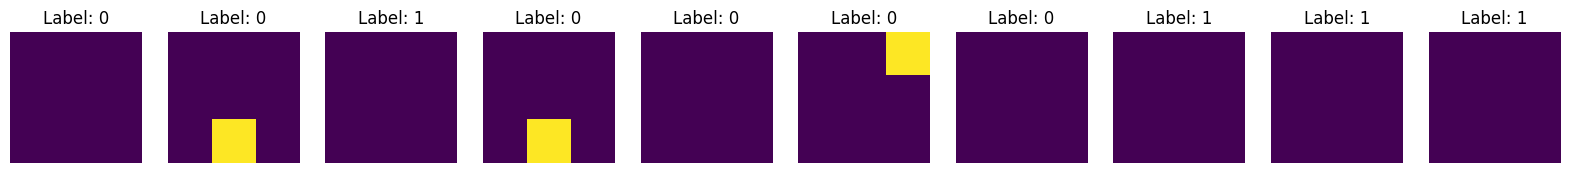

In [132]:
show_images(training_data)

In [65]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion(x_0, t, device=device):
    # Returns noisy version of the image at a time stamp
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# Define time steps
T = 500
betas = linear_beta_schedule(timesteps=T)

# Initialize terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

5 3


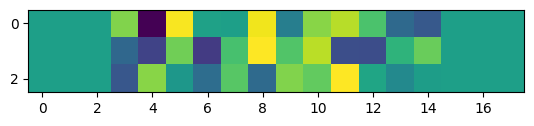

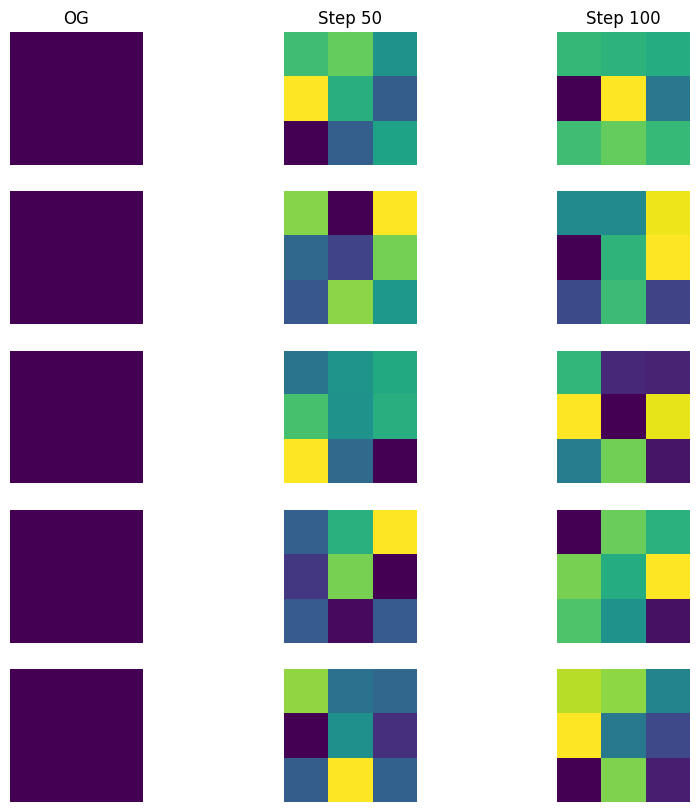

In [124]:
def get_noised_images(images, step, alphas_comulative_product):
    sqr_cp_alphas = np.sqrt(alphas_comulative_product[step])
    sqr_one_minus_cp_alphas = np.sqrt(1-alphas_comulative_product[step])
    eps  = torch.randn_like(images)
    noised_images = sqr_cp_alphas*images + sqr_one_minus_cp_alphas*eps
    return noised_images, eps

def plot_grid(images, labels):
    fig, axs = plt.subplots(images.shape[0], images.shape[1], figsize=(10,10))
    for i in range(images.shape[0]):
        for j in range(images.shape[1]):
            axs[i, j].imshow(images[i, :, (j*3):((j+1)*3)])
            try:
                axs[i, j].set_title(labels[i][j])
            except:
                pass
            axs[i, j].axis('off')
    
images, labels = next(iter(train_dataloader))
image = images[0:5]
noised_image_50, _ = get_noised_images(image, 50, alphas_cumprod)
noised_image_100, _ = get_noised_images(image, 100, alphas_cumprod)
noised_image_300, _ = get_noised_images(image, 300, alphas_cumprod)
noised_image_400, _ = get_noised_images(image, 400, alphas_cumprod)
noised_image_499, _ = get_noised_images(image, 499, alphas_cumprod)

images_concat = torch.cat((image, noised_image_50, noised_image_100, noised_image_300, noised_image_400, noised_image_499), dim=2)
import matplotlib.pyplot as hz

hz.imshow(images_concat[1])
print(images_concat.shape[0], images_concat.shape[1])
# Plot the images
labels = [['OG', 'Step 50', 'Step 100', 'Step 300', 'Step 400', 'Step 499']]
plot_grid(images_concat, labels)
